# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_24738/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import glob,imp,os,shutil
/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_24738/1200496628.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


#### Create txname/process translator

In [2]:
processDict = {'TRV1tt' : r'$p p \to \bar{t} t$',
               'TRV1jj' : r'$p p \to j j$',
               'TRV1bb' : r'$p p \to \bar{b} b$',
               'TRV1qq' : r'$p p \to \bar{q} q$',
               'TRV1' : r'$p p \to \chi \chi$',
               'TRS1' : r'$p p \to \chi \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    return newlabel

### Scan over $\alpha$ 

In [3]:
#Merge with SModelS DataFrame
# pclFiles = {'all': '../../data/2mdm_results_scan_alpha_v3/all/results.pcl',
#             'zp': '../../data/2mdm_results_scan_alpha_v3/zp_only/results.pcl',
#             'sd': '../../data/2mdm_results_scan_alpha_v3/sd_only/results.pcl'}
pclFiles = {'sd': '../data/pcl_files/smodels_results_scan_alpha.pcl'}

dataDF = pd.DataFrame()
for label, f in pclFiles.items():
    df = pd.read_pickle(f)
    df['process'] = label
    dataDF = pd.concat((dataDF, df))

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

In [5]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c]

In [6]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [7]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [8]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [9]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [10]:
labels = []
for index, row in newDF.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF['label'] = labels
newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')


In [11]:
dfAll = newDF[(newDF['process']=='all')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [12]:
# plot values of r for sd only
dfSd = newDF[(newDF['process']=='sd')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [13]:
dfSd = dfSd[dfSd['extpar.1']==1.414214]

In [14]:
zpMasses = dfSd['mass.9900032'].unique().tolist()

In [39]:
atlas_curve = pd.read_csv('../data/fig_12b.csv', sep=', ')

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_24738/1473492523.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  atlas_curve = pd.read_csv('../data/fig_12b.csv', sep=', ')


In [40]:
atlas_curve

mS  sinalpha
0    10.017601  0.238530
1    20.038376  0.247962
2    50.126354  0.278556
3    80.031743  0.296515
4   100.262032  0.312924
5   149.938235  0.372587
6   199.369099  0.488791
7   249.294653  0.604999
8   299.722995  0.857696
9   348.452015  1.264021
10  398.319165  2.133648

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_24738/1053986503.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Spectral_r')


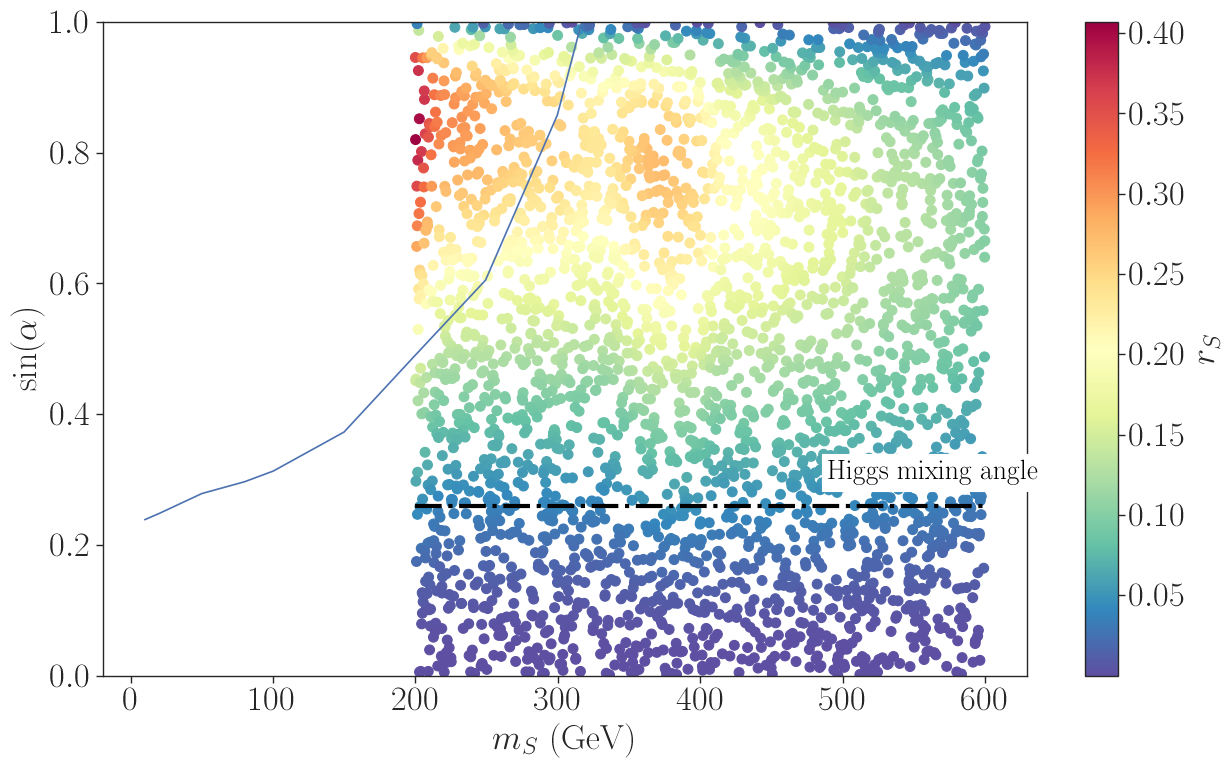

In [43]:
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(13,8))

mzp = 2000.0
data = dfSd[(dfSd['mass.9900032']==mzp)&(dfSd['ExptRes.result.r']>=0)]
x = data['mass.9900026']
y = data['extpar.6']
c = data['ExptRes.result.r']

plt.hlines(0.26, 200, 600, linestyle='dashdot', color='black',linewidth=3.0)
plt.plot(atlas_curve['mS'], atlas_curve['sinalpha'])

im = plt.scatter(x,y,c=c,s=50,cmap=cm)
cb = plt.colorbar(im)
cb.set_label(label=r'$r_{S}$', size=25)

#     ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
#                bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)

plt.ylim(0,1)
    
plt.xlabel(r'$m_{S}$ (GeV)', fontsize=25)
plt.ylabel(r'$\sin(\alpha$)', fontsize=25)
    
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
im.figure.axes[0].tick_params(axis="both", labelsize=25) 
im.figure.axes[1].tick_params(axis="y", labelsize=25) 
plt.text(490., 0.3, r'Higgs mixing angle', color='black', backgroundcolor='white', fontsize=20)


plt.tight_layout()
plt.savefig('./figures/2mdm_rs.png')

plt.show()

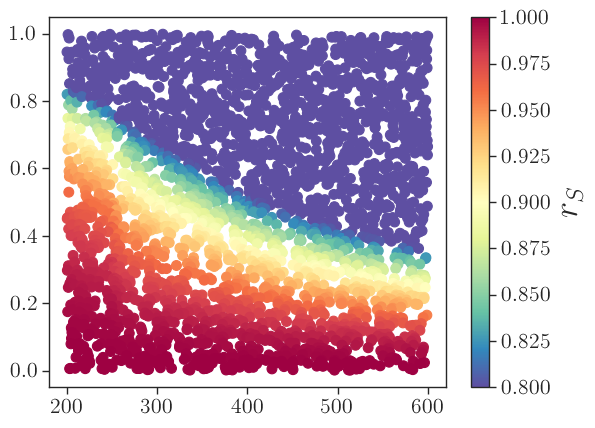

In [50]:
mzp = 2000.0
data = dfSd[(dfSd['mass.9900032']==mzp)&(dfSd['ExptRes.result.r']>=0)]
x = data['mass.9900026']
y = data['extpar.6']
c = data['BRs.sd.chi,chi']

im = plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8, vmax=1.0)
cb = plt.colorbar(im)
cb.set_label(label=r'$r_{S}$', size=25)

plt.show()

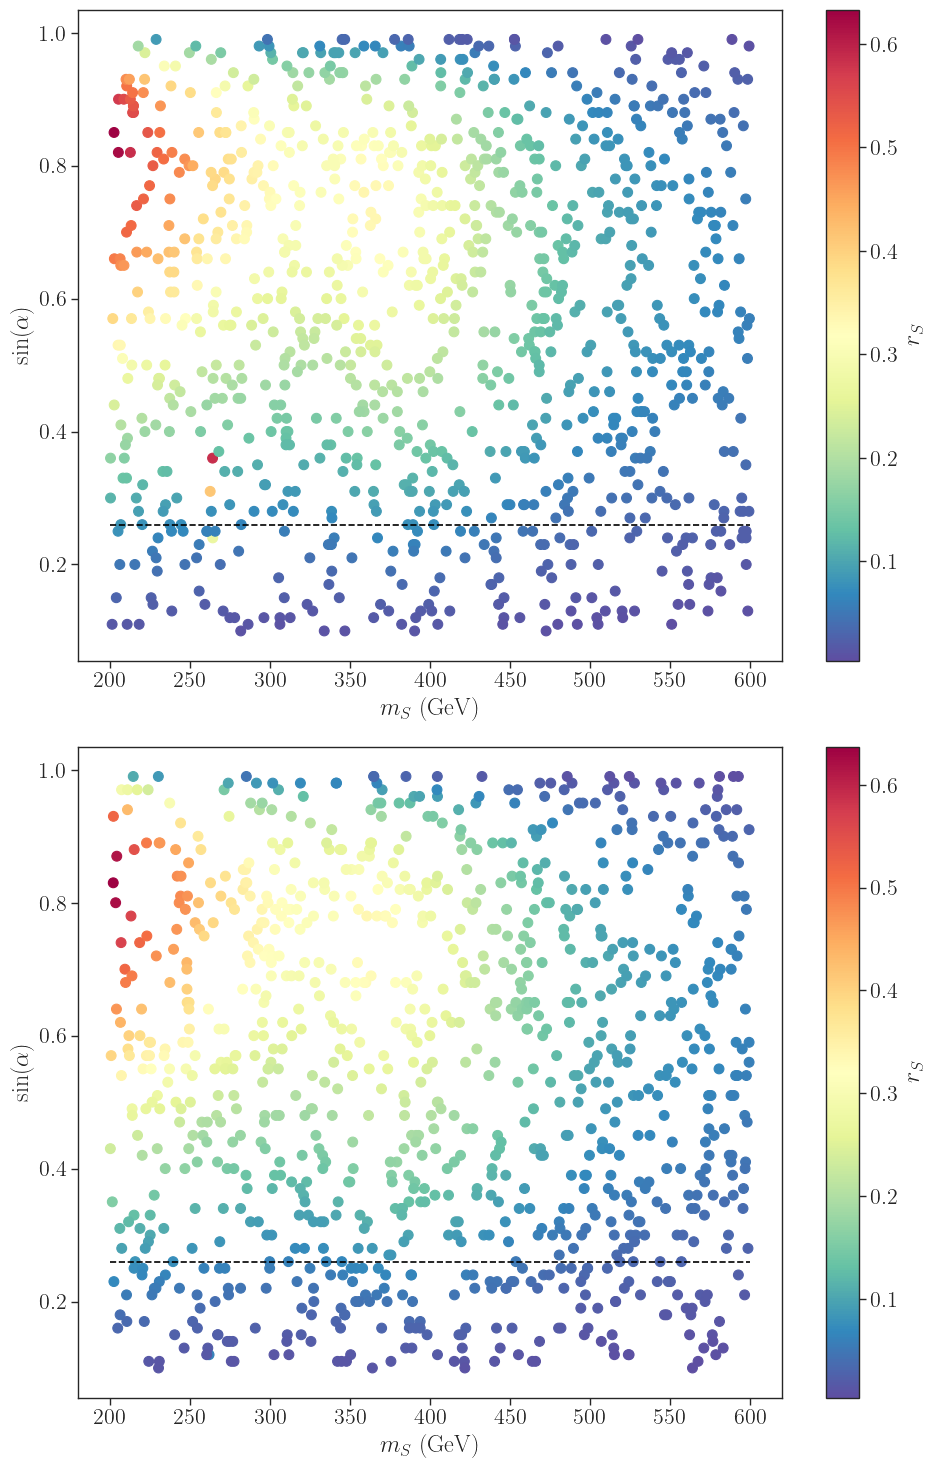

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
fig, ax = plt.subplots(len(zpMasses), figsize=(10,15))

zpMasses.sort()
for i, mzp in enumerate(zpMasses):
    x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
    y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
    c = dfSd['ExptRes.result.r'][dfSd['mass.9900032']==mzp]
    
    ax[i].hlines(0.26, 200, 600, linestyle='--', color='black')
    
    im = ax[i].scatter(x,y,c=c,s=50,cmap=cm)
    plt.colorbar(im, label=r'$r_{S}$', ax=ax[i])
    
#     ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
#                bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)
    
    ax[i].set_xlabel(r'$m_{S}$ (GeV)')
    ax[i].set_ylabel(r'$\sin(\alpha$)')
    

fig.tight_layout()
plt.show()

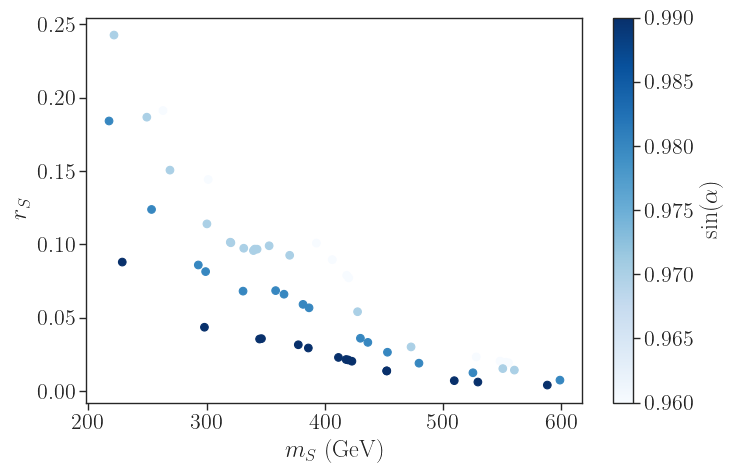

In [ ]:
cm = plt.cm.get_cmap('Blues')
plt.figure(figsize=(8,5))

m = 1750
sa = 0.95
x = dfSd['mass.9900026'][(dfSd['extpar.6']>sa)&(dfSd['mass.9900032']==m)]
y = dfSd['ExptRes.result.r'][(dfSd['extpar.6']>sa)&(dfSd['mass.9900032']==m)]
c = dfSd['extpar.6'][(dfSd['extpar.6']>sa)&(dfSd['mass.9900032']==m)]


im = plt.scatter(x, y, c=c, s=30,cmap=cm)
plt.colorbar(im, label=r'$\sin(\alpha)$')

plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$r_{S}$')
plt.show()

In [ ]:
dfZp = newDF[(newDF['process']=='zp')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [ ]:
dfAll = dfAll[dfAll['ExptRes.result.r']>=0.6]

In [ ]:
# dfZp = dfZp[dfZp['ExptRes.result.r']>=0.4]

In [ ]:
dfAll = dfAll.drop_duplicates(subset='filename')

In [ ]:
mCols = ['mass.9900026', 'mass.9000006']
keys = list(dfAll[mCols].columns.values)
i1 = dfAll.set_index(keys).index
i2 = dfZp.set_index(keys).index
dfAll = dfAll[i1.isin(i2)]
dfZp = dfZp[i2.isin(i1)]

print(len(dfAll), len(dfZp))

4000 4000


In [ ]:
dfAll = dfAll.sort_values(by=['mass.9900026', 'extpar.6'])
dfZp = dfZp.sort_values(by=['mass.9900026','extpar.6'])

In [ ]:
zpMasses = dfAll['mass.9900032'].unique().tolist()

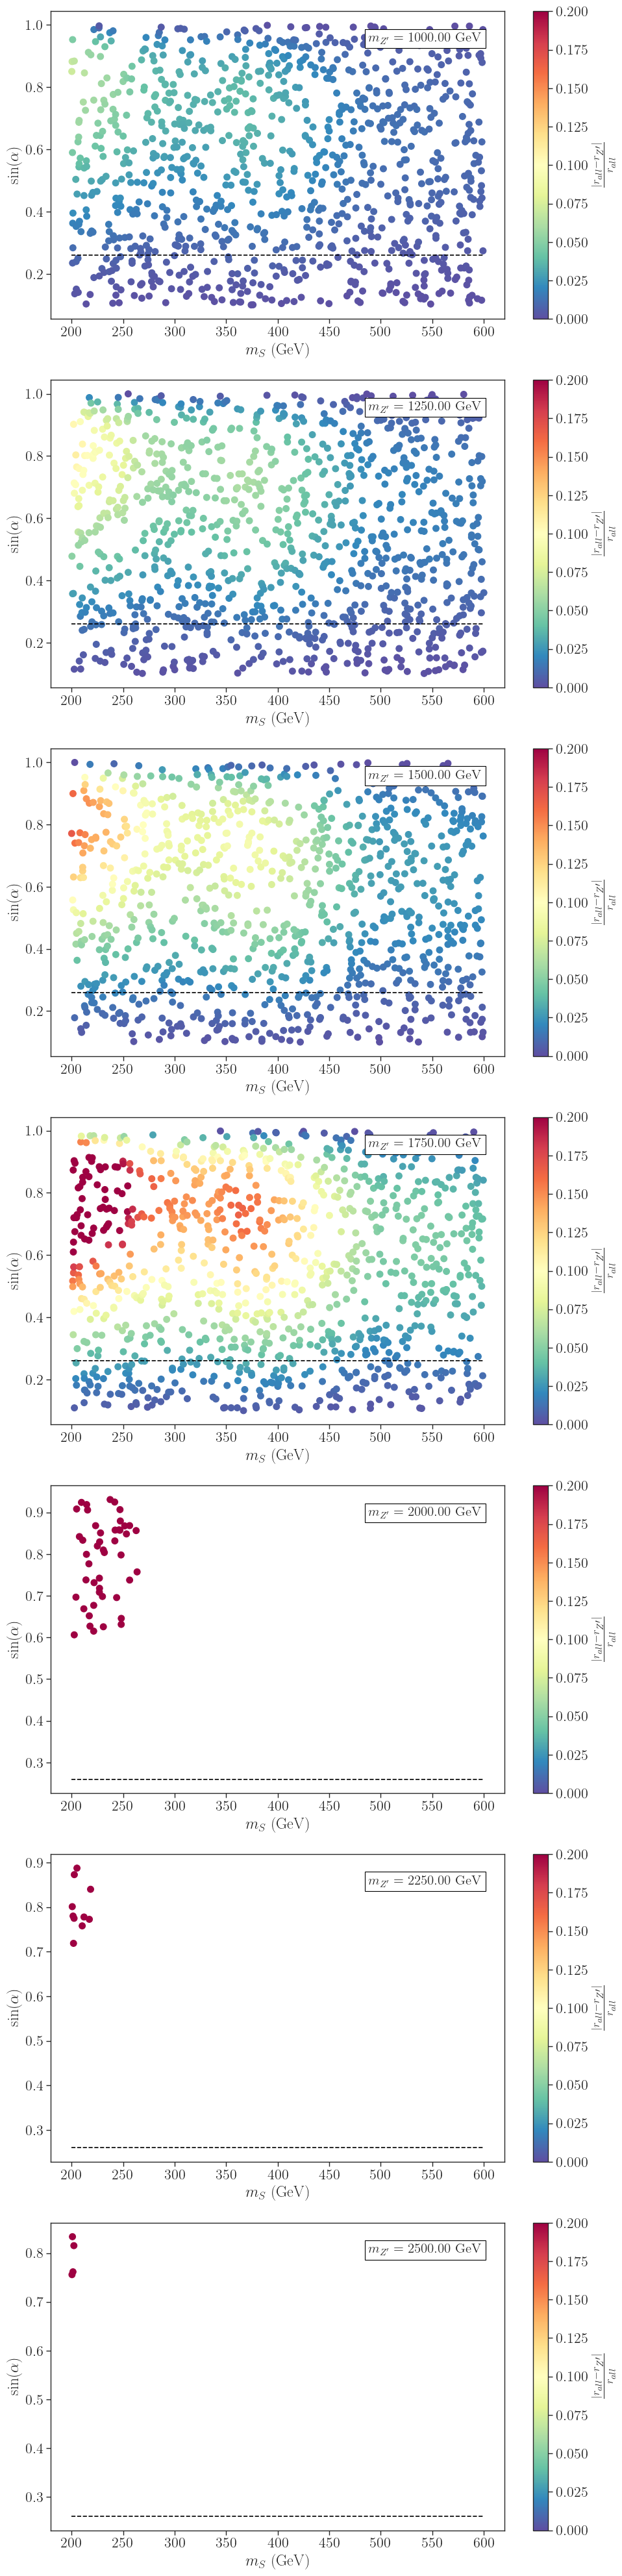

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
fig, ax = plt.subplots(len(zpMasses), figsize=(10,40))

zpMasses.sort()
for i, mzp in enumerate(zpMasses):
    rAll = np.array(dfAll['ExptRes.result.r'][dfAll['mass.9900032']==mzp])
    rZp = np.array(dfZp['ExptRes.result.r'][dfZp['mass.9900032']==mzp])
    rDiff = np.abs(rAll - rZp)/rAll
    
    x = dfAll['mass.9900026'][dfAll['mass.9900032']==mzp]
    y = dfAll['extpar.6'][dfAll['mass.9900032']==mzp]
    c = rDiff
    
    ax[i].hlines(0.26, 200, 600, linestyle='--', color='black')
    
    im = ax[i].scatter(x,y,c=c,s=50,cmap=cm, vmin=0, vmax=0.2)
    plt.colorbar(im, label=r'$\frac{|r_{all} - r_{Z^{\prime}}|}{r_{all}}$', ax=ax[i])
    
    ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
               bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)
    
    ax[i].set_xlabel(r'$m_{S}$ (GeV)')
    ax[i].set_ylabel(r'$\sin(\alpha$)')
    

fig.tight_layout()
plt.show()

In [ ]:
mzp = 1750

In [ ]:
r_diff = np.abs(np.array(dfAll['ExptRes.result.r'][dfAll['mass.9900032']==mzp]) 
                - np.array(dfZp['ExptRes.result.r'][dfZp['mass.9900032']==mzp]))/np.array(dfAll['ExptRes.result.r'][dfAll['mass.9900032']==mzp])

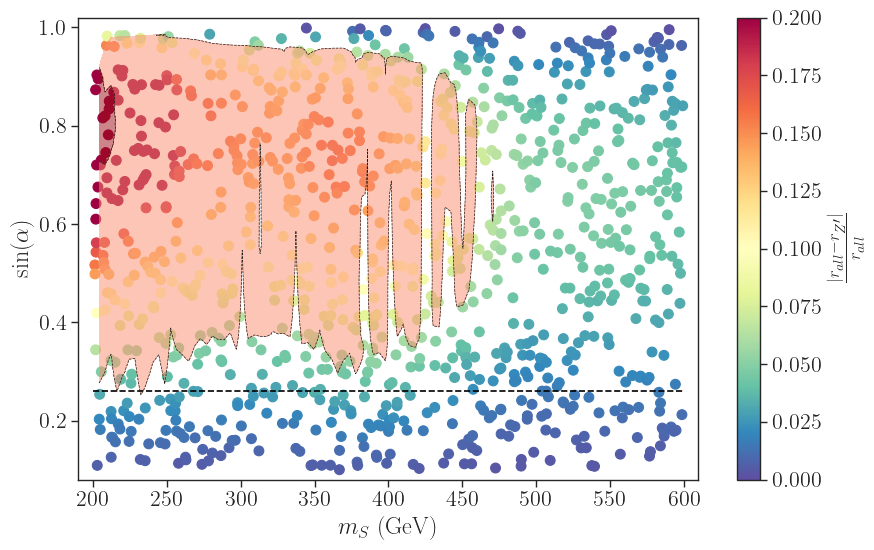

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,6))

x = dfAll['mass.9900026'][dfAll['mass.9900032']==mzp]
y = dfAll['extpar.6'][dfAll['mass.9900032']==mzp]
c = r_diff

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0, vmax=0.2)

plt.colorbar(label=r'$\frac{|r_{all} - r_{Z^{\prime}}|}{r_{all}}$')
plt.hlines(0.26, 200, 600, linestyle='--', color='black')

data = dfAll[dfAll['mass.9900032']==mzp]
rData = data['ExptRes.result.r']
pts = np.array([y for y in product(np.linspace(200,600.,100), np.linspace(0.0,1.0,100))])
rPts = griddata(list(zip(data['mass.9900026'], data['extpar.6'])),rData,pts)
pts = pts[~np.isnan(rPts)]
rPts = rPts[~np.isnan(rPts)]

cs = plt.tricontour(pts[:,0],pts[:,1],rPts, levels=[0.8, 1.0], colors='k', linewidths=0.5, linestyles='dashed')


plt.tricontourf(pts[:,0],pts[:,1],rPts, levels=[0.8, 1.0, rPts.max()],cmap='Reds', alpha=0.5)



plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

plt.show()

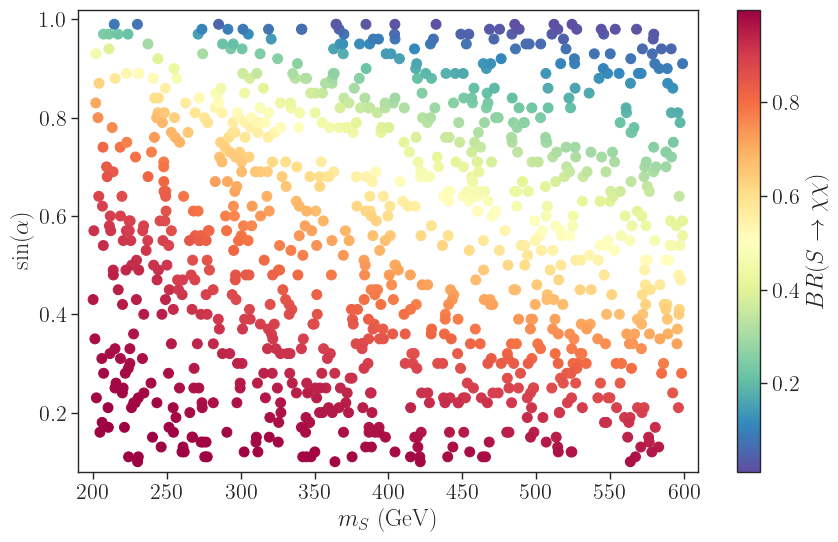

In [ ]:
# Plot scalar BR
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,6))
mzp = 2000
x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
c = dfSd['BRs.sd.chi,chi'][dfSd['mass.9900032']==mzp]

plt.scatter(x,y,c=c,s=50,cmap=cm)

plt.colorbar(label=r'$BR(S \to \chi \chi)$')

plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

plt.show()

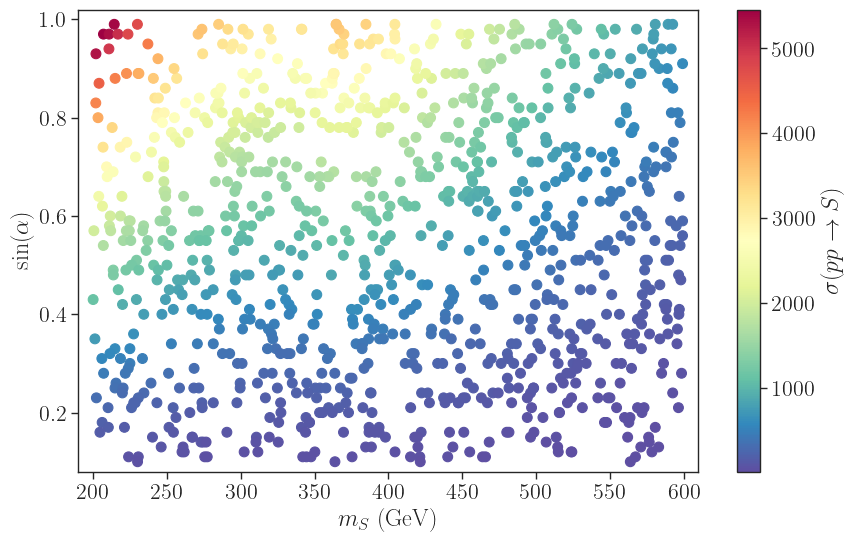

In [ ]:
# plot xsec
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,6))
mzp = 2000
x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
c = dfSd['xsec13TeV(fb).9900026'][dfSd['mass.9900032']==mzp]

plt.scatter(x,y,c=c,s=50,cmap=cm)

plt.colorbar(label=r'$\sigma(p p \to S)$')

plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

plt.show()

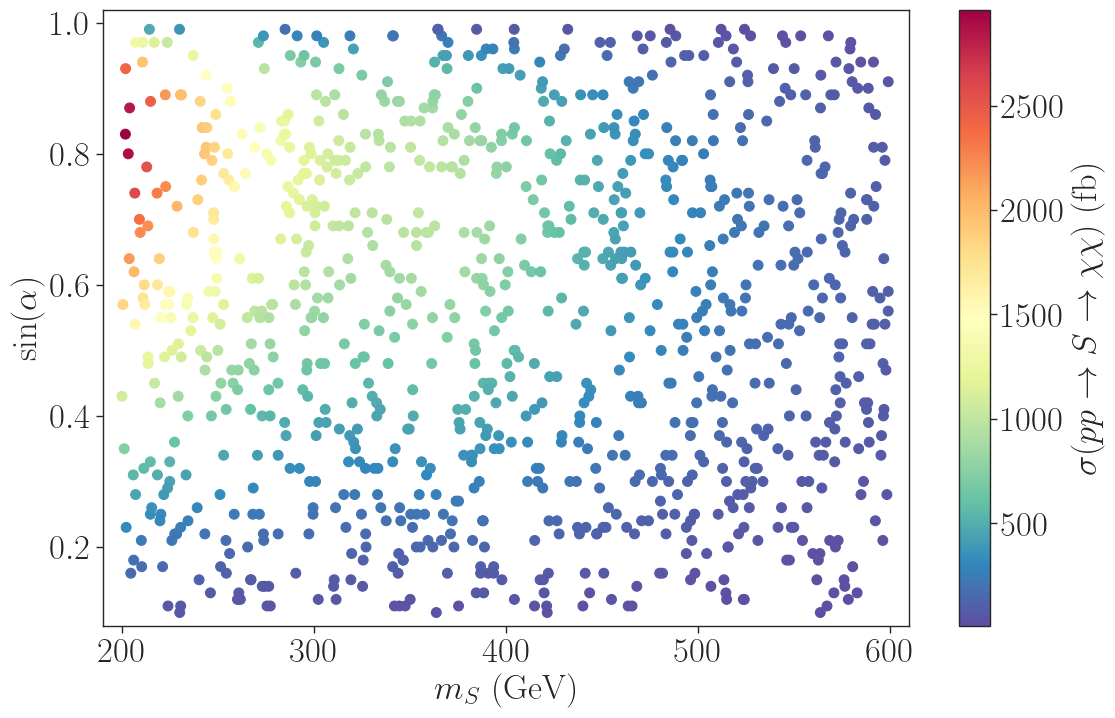

In [ ]:
# plot xsec * br
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(13,8))
mzp = 2000
x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
c = dfSd['xsec13TeV(fb).9900026'][dfSd['mass.9900032']==mzp]*dfSd['BRs.sd.chi,chi'][dfSd['mass.9900032']==mzp]

im = plt.scatter(x,y,c=c,s=50,cmap=cm)

cb = plt.colorbar(im)
cb.set_label(label=r'$\sigma(p p \to S \to \chi \chi)$ (fb)', size=25)


plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)', fontsize=25)
plt.ylabel(r'$\sin(\alpha$)', fontsize=25)


im.figure.axes[0].tick_params(axis="both", labelsize=25) 
im.figure.axes[1].tick_params(axis="y", labelsize=25) 

plt.savefig('2mdm-xsection-s.png')
plt.show()

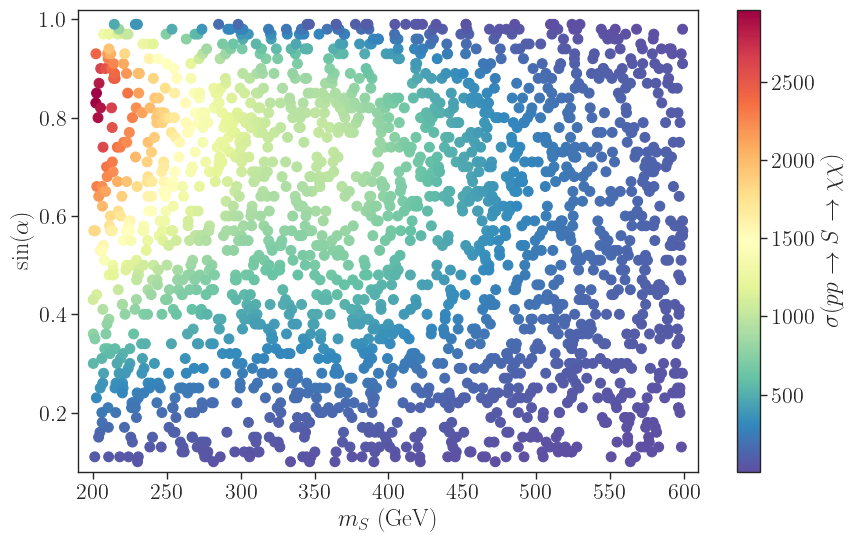

In [ ]:
# plot xsec * br
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,6))
x = dfSd['mass.9900026']
y = dfSd['extpar.6']
c = dfSd['xsec13TeV(fb).9900026']*dfSd['BRs.sd.chi,chi']

plt.scatter(x,y,c=c,s=50,cmap=cm)

plt.colorbar(label=r'$\sigma(p p \to S \to \chi \chi)$')

plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

# plt.savefig('2mdm-xsection-s.png')
plt.show()

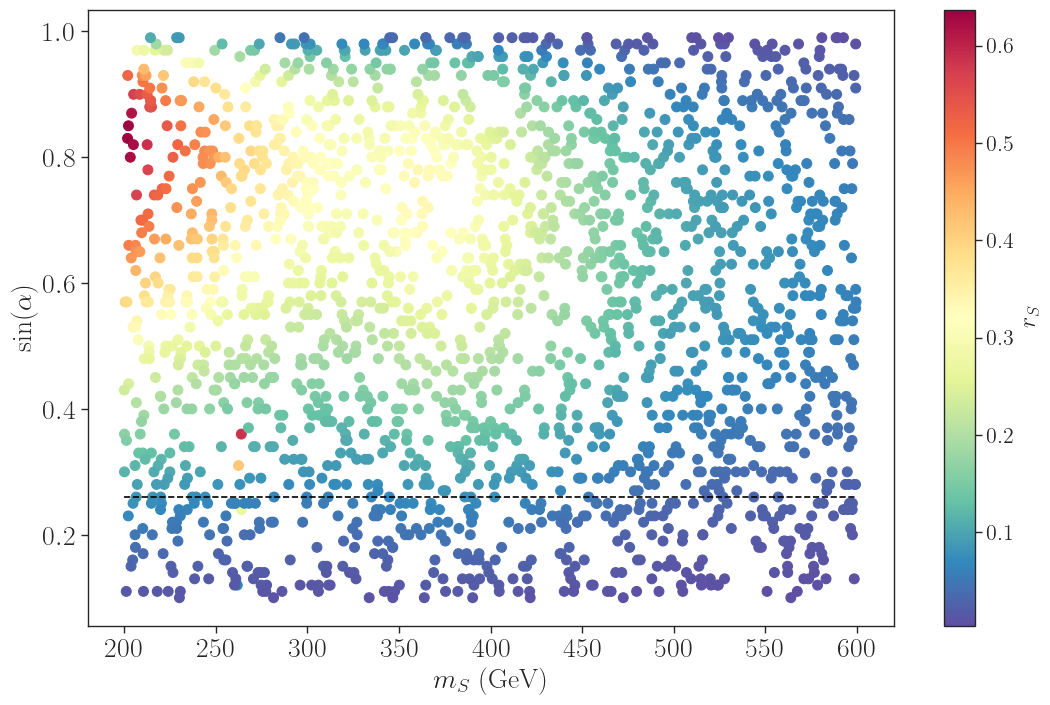

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(13,8))

mzp = 2000.0
x = dfSd['mass.9900026']
y = dfSd['extpar.6']
c = dfSd['ExptRes.result.r']

plt.hlines(0.26, 200, 600, linestyle='--', color='black')

im = plt.scatter(x,y,c=c,s=50,cmap=cm)
plt.colorbar(im, label=r'$r_{S}$')
    
#     ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
#                bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)
    
plt.xlabel(r'$m_{S}$ (GeV)', fontsize=20)
plt.ylabel(r'$\sin(\alpha$)', fontsize=20)
    
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# plt.savefig('2mdm_rs.png')
fig.tight_layout()
plt.show()

In [ ]:
dfAll['extpar.1']

2369     1.0
53894    1.0
79182    1.0
60995    1.0
53899    1.0
        ... 
58347    1.0
1481     1.0
5511     1.0
33597    1.0
81872    1.0
Name: extpar.1, Length: 4000, dtype: float64

In [ ]:
2.1747*3.423461e-01 + 3.2556*3.053258e-01

1.7385187381499998

In [32]:
mzp = np.random.uniform(200, 4000, 1000)

In [34]:
mchi = np.random.uniform(200, mzp/2, 1000)

In [35]:
mchi

array([ 212.71188889,  613.65854226,  361.20145519,  257.72401367,
       1380.07480911,  238.72488678,  671.45037445, 1109.91534249,
        715.26824868,  413.40529187,  486.43626397,  363.95153093,
        250.52687658,  400.47545156,  315.16698704,  960.24718585,
        326.74215795,  936.65874647,  321.35186586, 1017.97759098,
       1524.81090046,  383.23543982,  361.01315113, 1159.42654073,
        293.97749663,  540.2192844 ,  370.00540586,  258.24065413,
        523.33772308,  238.54849439, 1542.99048645,  363.89073548,
        198.92195484,  259.61889436,  373.79528682,  236.42550865,
       1226.3735382 ,  619.15429452,  192.18244987, 1329.22040079,
        808.53506936,  200.19780203,  699.87258425,  338.00350648,
        495.3153331 , 1532.48005453,  840.7808427 , 1383.27999255,
        217.32725408, 1372.34522515,  651.77381967,  676.69191906,
        360.25897213,  251.1451462 ,  727.26006755,  380.1074493 ,
        315.02043077,  587.97578339,  538.74310365, 1265.53237

In [43]:
for i, m in enumerate(mzp):
    print('('+str(mchi[i])+', '+str(m)+')', end=',')

(212.71188889082592, 926.5810774992235),(613.6585422601296, 2043.162405687314),(361.2014551921616, 3787.5135408512897),(257.7240136706714, 1855.043621912349),(1380.0748091126682, 3857.0172907538927),(238.72488677955425, 1185.9716817146125),(671.4503744543902, 1799.8429503970328),(1109.915342487301, 3411.8230099878874),(715.2682486819505, 3676.5772267492566),(413.4052918663597, 3376.3050188232537),(486.4362639654368, 2833.145994070833),(363.9515309302228, 887.3361643418485),(250.5268765807862, 661.0062481588295),(400.47545156239414, 1023.5898633476392),(315.16698703985855, 1821.8014322067654),(960.2471858531657, 3523.5349162235093),(326.74215795163934, 1472.861451139092),(936.6587464749922, 2404.6536935144545),(321.35186586250836, 3886.656117858173),(1017.977590983509, 3241.0682269573053),(1524.810900462939, 3259.714911682743),(383.2354398206834, 1306.4729550448803),(361.01315112666316, 1153.4049200490854),(1159.4265407262615, 2652.3530301141805),(293.9774966309502, 1167.7322493593272),